# Coletando dados das Estatísticas Fiscais
Estudo inspirado em Análise Macro

## Política Fiscal
De acordo com Asaf Neto, a política fiscal "centraliza suas preocupações nos gastos dos setor público e nos imopostos cobrados da sociedade, procurando, por meio de maior eficácia no equilíbrio entre a arrecadação tributáriae as despesas governamentais, atingir determinados objetivos macroeconômicos e sociais. 

Como dito anteriormente, a política fiscal é exercida pela arrecadação de impostos e pelos gastos públicos. O resultado desse equilíbrio se apresentará como superávit ou déficit fiscal. Tal polítca no curto prazo afeta mais diretamente a demanda da economia, e no longo prazo, o crescimento e a poupança. A alteração nos impostos por parte do governo influencia a capacidad ede consumo e poupança das famílias. 

O BACEN disponibiliza as Estatísticas Fiscais, e por meio da entidade que podemos consultar os resultados do Setor Público Consolidado (Governo federal, estados, municípios e estatais). Os indicadores que buscaremos serão:

1. Resultado nominal - Total - Setor público consolidado (sem desvalorização cambial): representa a variação nominal dos saldos da dívida líquida, fornecendo também informações sobre o confronto entre receitas e despesas totais, ou seja, se houve superávit ou déficit.

2. Juros Nominais - Total - Setor público consolidado (sem desvalorização cambial): representa o fluxo dejuros, incidentes sobre a dívida interna e externa do pais. É determinado pelo nível da taxa de juros nominal e pela dimensão do estoque da dívida.

3. Resultado Primário - Total - Setor público consolidado (sem desvalorização cambial): corresponde ao resultado nominal menos o juros nominais.

Utilizadremos as biblioteca python-bcb, que nos fornecerá o módulo sgs (Sistema Gerenciador de Séries Temporais)

## Importando as bibliotecas

In [1]:
from bcb import sgs
import ipeadatapy as ip
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

## Coletando os dados
Em notebooks anteriores, cada indicador possui um código dentro do SGS, por isso devemos indicar quais destes serão utilizados.

In [3]:
# Buscando as séries por meio do SGS
fisc = sgs.get({'Resultado Primário - SPC' : 4649,
                'Juros Nominais - SPC' : 4616,
                'Resultado Nominal - SPC' : 4583})

In [4]:
fisc

,Resultado Primário - SPC,Juros Nominais - SPC,Resultado Nominal - SPC
Date,,,
2001-12-01,5055.20,8318.66,13373.86
2002-01-01,-6509.82,8110.70,1600.88
2002-02-01,-4655.74,8360.16,3704.44
2002-03-01,-4225.36,7095.78,2870.42
2002-04-01,-7100.23,7012.64,-87.57
...,...,...,...
2021-12-01,-123.19,54371.79,54248.60
2022-01-01,-101833.12,17771.88,-84061.23
2022-02-01,-3470.90,26015.79,22544.90


Muito cuidado! Estes dados obtidos indicam os preços a mercado, portanto é interessante deflacionar os dados e verificar como os indices se comportaram ao longo do tempo

Assim, devemos buscar a série do IPCA para que possamos deflacionar os dados. Para tal, utilizarei a biblioteca ipeadatapy para capturar os dados do IPCA.

In [5]:
# Série do índice do IPCA e renomeia a coluna de valor
ipca = (ip.timeseries('PRECOS12_IPCA12')
       [['VALUE (-)']].rename(columns = {'VALUE (-)' : 'ipca'}))

In [6]:
ipca

,ipca
DATE,
1979-12-01,7.618300e-09
1980-01-01,8.122300e-09
1980-02-01,8.497300e-09
1980-03-01,9.010400e-09
1980-04-01,9.486700e-09
...,...
2022-01-01,6.153090e+03
2022-02-01,6.215240e+03
2022-03-01,6.315930e+03


In [7]:
fiscal_ipca = fisc.join(ipca)

Com os dados já preparados, precisamos aplicar o **cálculo de deflacionamento** na série das Estatísticas Fiscais. Após a construção do deflator, o multiplicamos com os valores dos dados utilizando o método mult().

In [9]:
# Calculo do deflator
deflator = fiscal_ipca['ipca'].iloc[-1] / fiscal_ipca.loc[:,['ipca']]

#Multiplica os valores pelo deflator para obter os valores reais
fiscal_real = fisc.mul(deflator.ipca, axis = 'index')

In [10]:
fiscal_real

,Resultado Primário - SPC,Juros Nominais - SPC,Resultado Nominal - SPC
Date,,,
2001-12-01,17800.863364,29292.477059,47093.340422
2002-01-01,-22804.377350,28412.377511,5608.000162
2002-02-01,-16250.891226,29181.193707,12930.372292
2002-03-01,-14660.697559,24620.170714,9959.473154
2002-04-01,-24440.049000,24138.551177,-301.428981
...,...,...,...
2021-12-01,-128.480694,56706.918738,56578.438044
2022-01-01,-105636.125099,18435.579102,-87200.535624
2022-02-01,-3564.518537,26717.498548,23152.990281


Utilizaremos o método _rolling()_ e _sum()_ para criar uma janela móvel de 12 meses para que seja feito a soma dos valores. Essa acumulação é útil para que possamos interpretar os caminhos dos resultados fiscais em um período de os caminhos dos resultados fiscais em um período de tempo maior, ao invés de observar períodos de curto prazo.

In [12]:
# Calcula os valores acumulados em 12 meses
fiscal_real_12 = fiscal_real.rolling(12).sum().dropna()

A partir de agora, podemos enfim analisar os resultados das estatísticas fiscais por meio de gráficos, plotando as séries utilizando o seaborn e o matplotlib

## Plotando os gráficos

Text(0, 0.5, 'R$ Bilhões')

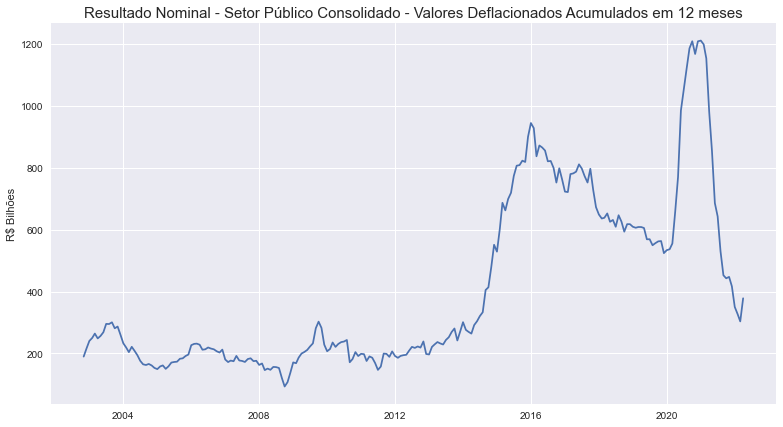

In [16]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(13,7))

#Plotting
sns.lineplot(data=fiscal_real_12['Resultado Nominal - SPC'] / 1000)
plt.title('Resultado Nominal - Setor Público Consolidado - Valores Deflacionados Acumulados em 12 meses', fontsize = 15)
plt.xlabel("")
plt.ylabel("R$ Bilhões")

Text(0, 0.5, 'R$ Bilhões')

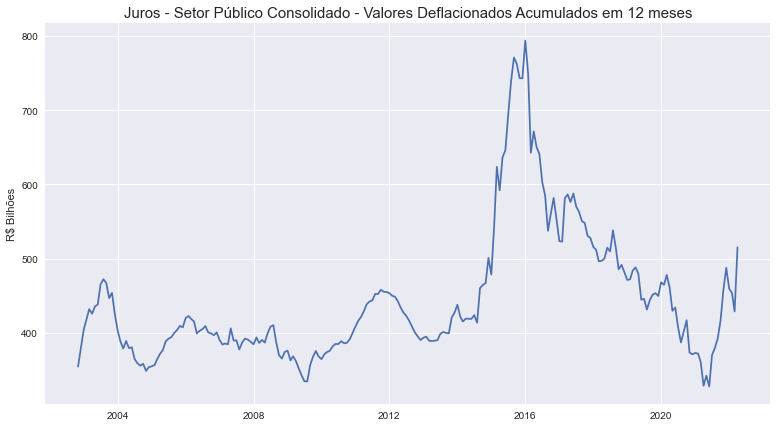

In [18]:
# Plota juros SPC

fig, ax = plt.subplots(figsize=(13,7))

#Plotting
plt.plot(fiscal_real_12['Juros Nominais - SPC'] / 1000)
plt.title('Juros - Setor Público Consolidado - Valores Deflacionados Acumulados em 12 meses', fontsize = 15)
plt.xlabel("")
plt.ylabel("R$ Bilhões")

Text(0, 0.5, 'R$ Bilhões')

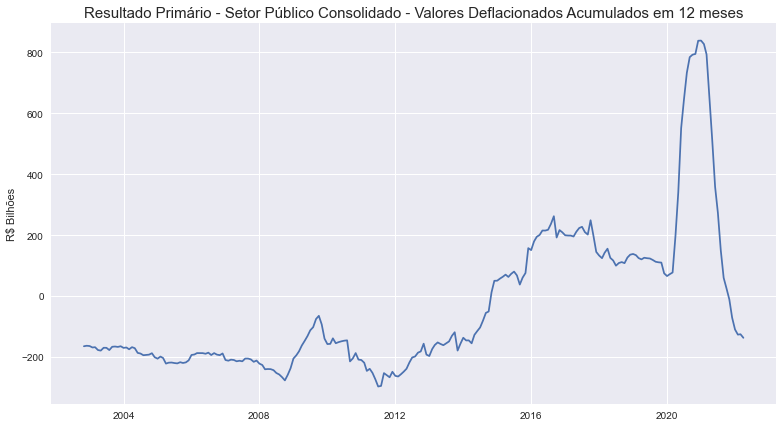

In [22]:
fig, ax = plt.subplots(figsize=(13,7))

#Plotting
sns.lineplot(data = fiscal_real_12['Resultado Primário - SPC'] / 1000)
plt.title('Resultado Primário - Setor Público Consolidado - Valores Deflacionados Acumulados em 12 meses', fontsize = 15)
plt.xlabel("")
plt.ylabel("R$ Bilhões")